# Homework 3  - Part B


###### Roll Number:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/cifar.zip','r')
zip_ref.extractall('/content/images')
zip_ref.close()

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [3]:
import keras
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import skimage
from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 21100086
np.random.seed(your_id)

Using TensorFlow backend.


###### Hyperparameters

In [0]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './images/cifar/'
epochs = 25
all_histories = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [5]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
#train_files = glob.glob('C:/Users/Ghazi Khan/Desktop/images_dir/cifar/train/**/*',  
#                   recursive = True) 
train_files=np.array(glob.glob(train_dir+'/*'))
print(train_files.shape)

#test_files = glob.glob('C:/Users/Ghazi Khan/Desktop/images_dir/cifar/test/**/*',  
#                        recursive = True) 
test_files=np.array(glob.glob(test_dir+'/*'))
print(test_files.shape)
'''
print(train_files[1])
img=skimage.io.imread(train_files[1])
label=train_files[1].split('_')[2].split('.')[0]
print(label)
skimage.io.imshow(img)
index = (data_generator(train_files, 5, True))
    
'''
#index = (data_generator(train_files, 32, True))
#index = (data_generator(train_files, 32, True))
#index = (data_generator(train_files, 1, True))

# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
train_files,val_files =train_test_split(train_files,test_size=0.1,random_state=41) 

(50000,)
(10000,)


In [0]:
x,y = next(index)
print(y)


[3 2 9 0 6 5 9 4 0 0 6 6 1 6 5 1 6 0 8 8 3 3 7 4 2 4 8 5 5 2 1 3]


### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [0]:
def preprocessing_norm(images):
    return np.divide(images,255)
    pass

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [0]:
def preprocessing_meanShift(images):
    means = np.mean(images,axis=(0,1))
    stds=np.std(images,axis=(0,1))
    return ((images-means)/stds)
    pass

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [0]:
def data_generator( x , batch_size = 32, preprocessing = None):
  while True:
    batch=[]
    lab=[]
    k=53
    for i in range(len(x)):
        #img=skimage.io.imread(x[i])
        img=cv2.imread(x[i])
        #img=preprocessing_norm(img)
        #img=img.reshape(32,32,3)
        label=x[i].split('_')[1].split('.')[0]
        if label=='airplane':
          k=0
        elif label=='automobile':
          k=1
        elif label=='bird':
          k=2
        elif label=='cat':
          k=3
        elif label=='deer':
          k=4
        elif label=='dog':
          k=5
        elif label=='frog':
          k=6
        elif label=='horse':
          k=7
        elif label=='ship':
          k=8
        elif label=='truck':
          k=9
        #tup=(img,k)
        batch.append(img)
        lab.append(k)
        if (len(batch)==batch_size):
            if preprocessing=='Norm':
              batch=preprocessing_norm(batch)

            j=np.array(batch)
            k=np.array(lab)
            k = to_categorical(k, num_classes)
            yield (j,k)
            batch=[]
            lab=[]
        
    
  

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [60]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
#input_img = Input(shape=(), name='input_img')
input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu', name= 'conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu', name= 'conv2d_2')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_initial = Model(inputs=input_img, outputs=output_class)
'''model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation=’relu’))
model.add(Flatten())
model.add(Dense(10, activation=’softmax’))'''


'model = Sequential()\n#add model layers\nmodel.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))\nmodel.add(Conv2D(32, kernel_size=3, activation=’relu’))\nmodel.add(Flatten())\nmodel.add(Dense(10, activation=’softmax’))'

#### Compile model and plot

In [0]:
model_name = 'base_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [15]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

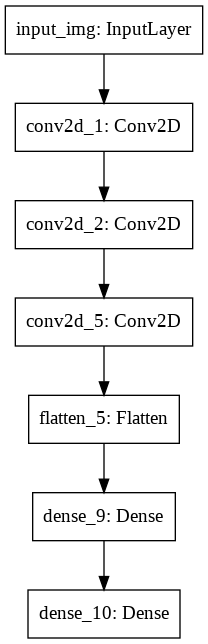

In [16]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [17]:
model_initial.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
flatten_5 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4640      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330 

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [0]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [0]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, csvlogger, reducelr]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [0]:
# Create three generators: For training your model, for validation, for testing.
train_gen=data_generator(train_files,batch_size,None)
test_gen=data_generator(test_files,batch_size,None)
val_gen=data_generator(val_files,batch_size,None)
vald,valt=next(val_gen)


In [21]:
# Start training your model here
hist_initial = model_initial.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_initial)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/25
703/703 [==============================] - 16s 22ms/step - loss: 2.4565 - acc: 0.1276 - val_loss: 2.1669 - val_acc: 0.1562

Epoch 00001: val_loss improved from inf to 2.16690, saving model to base_model/base_model-01-2.17.h5

Epoch 2/25
703/703 [==============================] - 9s 13ms/step - loss: 1.8851 - acc: 0.2963 - val_loss: 1.5434 - val_acc: 0.5312

Epoch 00002: val_loss improved from 2.16690 to 1.54336, saving model to base_model/base_model-02-1.54.h5
Epoch 3/25
703/703 [==============================] - 9s 13ms/step - loss: 1.6729 - acc: 0.3834 - val_loss: 1.4367 - val_acc: 0.5625

Epoch 00003: val_loss improved from 1.54336 to 1.43666, saving model to base_model/base_model-03-1.44.h5
Epoch 4/25
703/703 [==============================] - 9s 13ms/step - loss: 1.5828 - acc: 0.4193 - val_loss: 1.4391 - val_acc: 0.5625

Epoch 00004: val_loss did not improve from 1.43

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')

In [0]:
model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [0]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_preprocessed = Model(inputs=input_img, outputs=output_class)

In [0]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

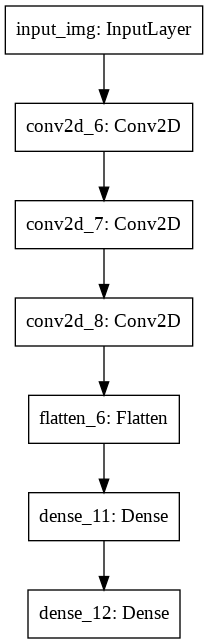

In [26]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [27]:
model_preprocessed.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 16)          4624      
_________________________________________________________________
flatten_6 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4640      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330 

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
#reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)

#callbacks = [checkpoint, tensorboard, csvlogger, reducelr]
callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three generators again
train_gen=data_generator(train_files,batch_size,'Norm')
test_gen=data_generator(test_files,batch_size,'Norm')
val_gen=data_generator(val_files,batch_size,'Norm')
vald,valt=next(val_gen)

In [30]:
hist_preprocessed = model_preprocessed.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_preprocessed)

Epoch 1/25
703/703 [==============================] - 10s 15ms/step - loss: 1.8339 - acc: 0.3316 - val_loss: 1.3563 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 1.35635, saving model to model_preprocessed_input/model_preprocessed_input-01-1.36.h5
Epoch 2/25
703/703 [==============================] - 10s 14ms/step - loss: 1.5194 - acc: 0.4508 - val_loss: 1.0974 - val_acc: 0.5938

Epoch 00002: val_loss improved from 1.35635 to 1.09742, saving model to model_preprocessed_input/model_preprocessed_input-02-1.10.h5
Epoch 3/25
703/703 [==============================] - 10s 14ms/step - loss: 1.4128 - acc: 0.4900 - val_loss: 1.0214 - val_acc: 0.5938

Epoch 00003: val_loss improved from 1.09742 to 1.02142, saving model to model_preprocessed_input/model_preprocessed_input-03-1.02.h5
Epoch 4/25
703/703 [==============================] - 10s 14ms/step - loss: 1.3532 - acc: 0.5170 - val_loss: 1.0017 - val_acc: 0.6094

Epoch 00004: val_loss improved from 1.02142 to 1.00168, saving mo

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [0]:
model_name = 'model_pooling'

input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu', name='conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu', name='conv2d_2')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [0]:
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [34]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 16)          4624      
_________________________________________________________________
flatten_8 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544 

In [0]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
#reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create generators
train_gen=data_generator(train_files,batch_size,'Norm')
test_gen=data_generator(test_files,batch_size,'Norm')
val_gen=data_generator(val_files,batch_size,'Norm')
vald,valt=next(val_gen)

In [38]:
hist_pooled = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
703/703 [==============================] - 10s 15ms/step - loss: 1.7800 - acc: 0.3467 - val_loss: 1.4185 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 1.41848, saving model to model_pooling/model_pooling-01-1.42.h5
Epoch 2/25
703/703 [==============================] - 10s 14ms/step - loss: 1.4523 - acc: 0.4722 - val_loss: 1.1689 - val_acc: 0.5156

Epoch 00002: val_loss improved from 1.41848 to 1.16890, saving model to model_pooling/model_pooling-02-1.17.h5
Epoch 3/25
703/703 [==============================] - 10s 14ms/step - loss: 1.3418 - acc: 0.5170 - val_loss: 1.0642 - val_acc: 0.5312

Epoch 00003: val_loss improved from 1.16890 to 1.06418, saving model to model_pooling/model_pooling-03-1.06.h5
Epoch 4/25
703/703 [==============================] - 10s 14ms/step - loss: 1.2729 - acc: 0.5461 - val_loss: 0.9888 - val_acc: 0.5938

Epoch 00004: val_loss improved from 1.06418 to 0.98875, saving model to model_pooling/model_pooling-04-0.99.h5
Epoch 5/25
703/703 [

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [39]:
model_name = 'model_dropout'

input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Dropout(rate=0.25)(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_dropout = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [41]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 32)          18464     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 16)          4624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16)                0   

In [0]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
#reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three Generators
train_gen=data_generator(train_files,batch_size,'Norm')
test_gen=data_generator(test_files,batch_size,'Norm')
val_gen=data_generator(val_files,batch_size,'Norm')
vald,valt=next(val_gen)

In [44]:
hist_dropout = model_dropout.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)

all_histories.append(hist_dropout)

Epoch 1/25
703/703 [==============================] - 11s 15ms/step - loss: 2.0225 - acc: 0.2247 - val_loss: 1.6871 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 1.68711, saving model to model_dropout/model_dropout-01-1.69.h5
Epoch 2/25
703/703 [==============================] - 10s 14ms/step - loss: 1.7716 - acc: 0.3209 - val_loss: 1.5047 - val_acc: 0.4688

Epoch 00002: val_loss improved from 1.68711 to 1.50471, saving model to model_dropout/model_dropout-02-1.50.h5
Epoch 3/25
703/703 [==============================] - 10s 14ms/step - loss: 1.6898 - acc: 0.3662 - val_loss: 1.4194 - val_acc: 0.4844

Epoch 00003: val_loss improved from 1.50471 to 1.41938, saving model to model_dropout/model_dropout-03-1.42.h5
Epoch 4/25
703/703 [==============================] - 10s 14ms/step - loss: 1.6406 - acc: 0.3883 - val_loss: 1.3685 - val_acc: 0.4844

Epoch 00004: val_loss improved from 1.41938 to 1.36850, saving model to model_dropout/model_dropout-04-1.37.h5
Epoch 5/25
703/703 [

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [0]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [46]:
input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu', name='conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu')(l)
l= BatchNormalization(axis=-1,momentum=0.88,epsilon=0.001)(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l= BatchNormalization(axis=-1,momentum=0.88,epsilon=0.001)(l)
l = Dropout(rate=0.25)(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_normalized = Model(inputs=input_img, outputs=output_class)

In [0]:
adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [48]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 32)          18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 32)          128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 16)          4624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1, 16)          64 

In [0]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

#reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
#callbacks = [checkpoint, tensorboard, csvlogger, reducelr]
callbacks = [checkpoint, tensorboard, csvlogger]

In [0]:
# Create three generators
train_gen=data_generator(train_files,batch_size,'Norm')
test_gen=data_generator(test_files,batch_size,'Norm')
val_gen=data_generator(val_files,batch_size,'Norm')
vald,valt=next(val_gen)

In [51]:
hist_normalized = model_normalized.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_normalized)

Epoch 1/25
703/703 [==============================] - 11s 16ms/step - loss: 2.0509 - acc: 0.2440 - val_loss: 1.5578 - val_acc: 0.4531

Epoch 00001: val_loss improved from inf to 1.55776, saving model to model_batch_normalized/model_batch_normalized-01-1.56.h5
Epoch 2/25
703/703 [==============================] - 11s 16ms/step - loss: 1.7084 - acc: 0.3645 - val_loss: 1.3397 - val_acc: 0.5781

Epoch 00002: val_loss improved from 1.55776 to 1.33970, saving model to model_batch_normalized/model_batch_normalized-02-1.34.h5
Epoch 3/25
703/703 [==============================] - 11s 16ms/step - loss: 1.6027 - acc: 0.4141 - val_loss: 1.2561 - val_acc: 0.5312

Epoch 00003: val_loss improved from 1.33970 to 1.25612, saving model to model_batch_normalized/model_batch_normalized-03-1.26.h5
Epoch 4/25
703/703 [==============================] - 11s 16ms/step - loss: 1.5343 - acc: 0.4446 - val_loss: 1.1924 - val_acc: 0.5781

Epoch 00004: val_loss improved from 1.25612 to 1.19242, saving model to model

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [0]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

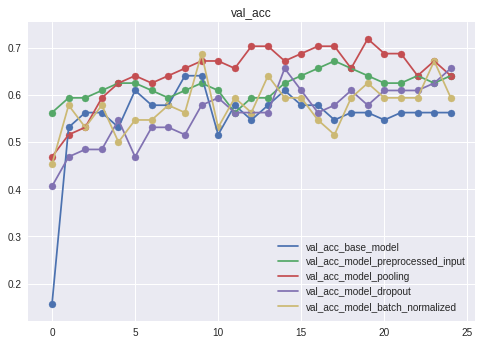

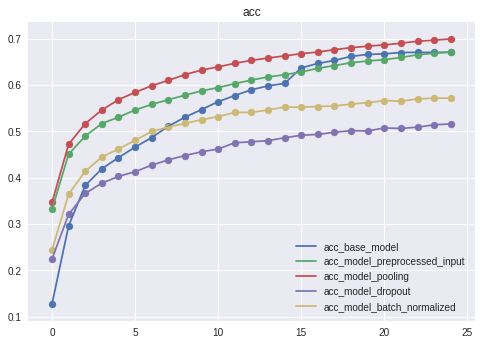

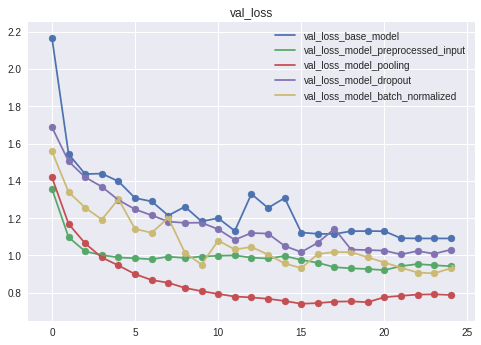

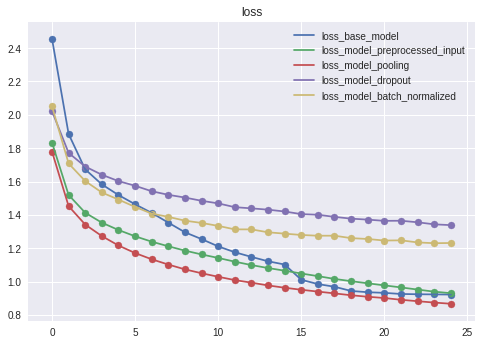

In [53]:
# Plot histories of all models
nam=['base_model','model_preprocessed_input','model_pooling','model_dropout','model_batch_normalized']
plotHistory(all_histories,nam,'val_acc')
plotHistory(all_histories,nam,'acc')
plotHistory(all_histories,nam,'val_loss')
plotHistory(all_histories,nam,'loss')


#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

In [117]:
tensorboard --logdir=path/to/log-directory/

SyntaxError: ignored

**Add cells to include loss plots**

##### Add your analysis here

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

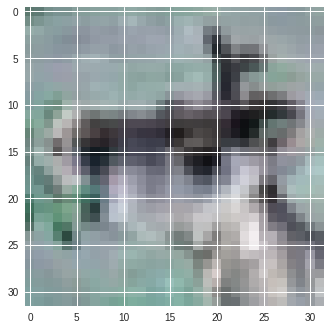

In [108]:
# Load any image here
#test_image = None
test_image =cv2.imread(val_files[221])
plt.imshow(test_image)

array([5])

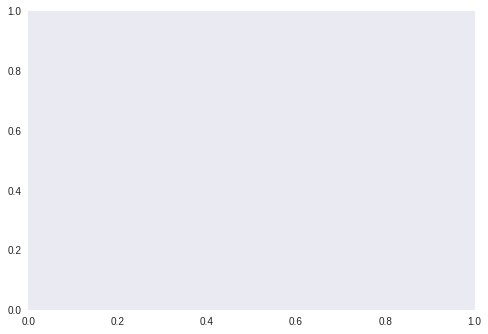

In [109]:
plt.gca().grid(False);

test_reshaped = test_image.reshape((1,32,32,3))

# Get a prediction from ANY ONE of your models and output its label
model_pooled.predict(test_image.reshape((1,32,32,3))).argmax(axis=1)

In [0]:
# Create a Model from the Input layer to a Convolutional Layer
new_model = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('conv2d_1').output)

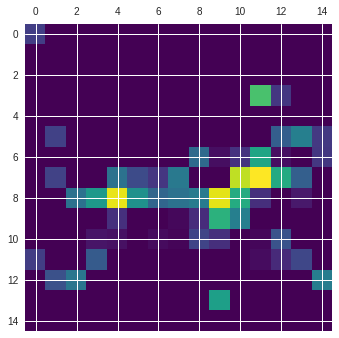

In [111]:
# Get a prediction for your chosen image using this model
#predicted_activations = None
con1_activations = new_model.predict(test_reshaped.reshape((1,32,32,3)))
con1_activations.shape
plt.matshow(con1_activations[0,:,:,0],cmap='viridis')
predicted_activations=con1_activations
plt.show()

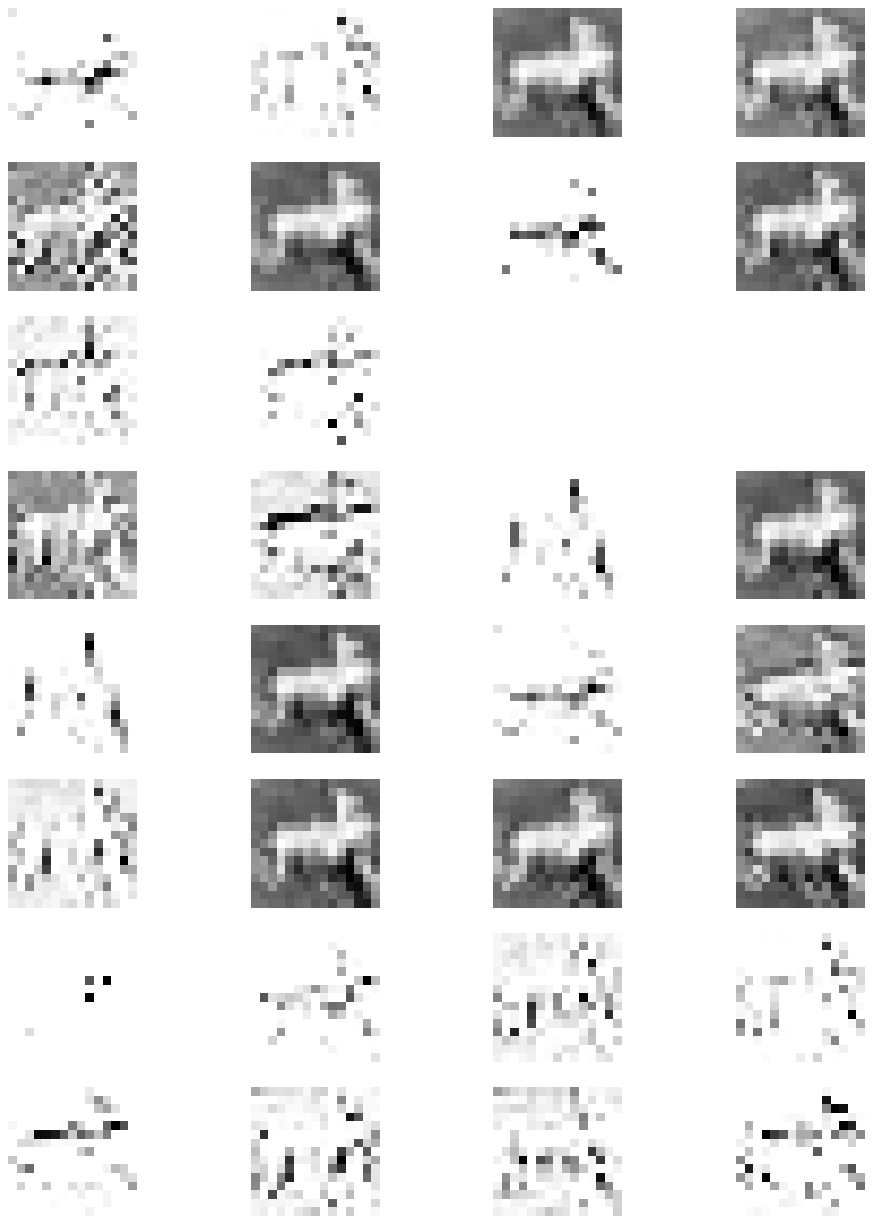

In [112]:
# Use your predictions to visualise the activations
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [0]:
# Create another model to visualize activations from ANOTHER convolutional layer
new_model2 = Model(inputs=input_img, 
                  outputs=model_pooled.get_layer('conv2d_2').output)

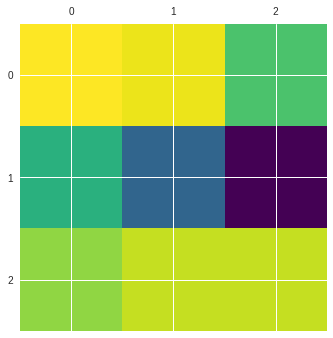

In [114]:
# You may rename this variable
#second_predicted_activations = None
con1_activations = new_model2.predict(test_reshaped.reshape((1,32,32,3)))
con1_activations.shape
plt.matshow(con1_activations[0,:,:,0],cmap='viridis')
second_predicted_activations=con1_activations
plt.show()

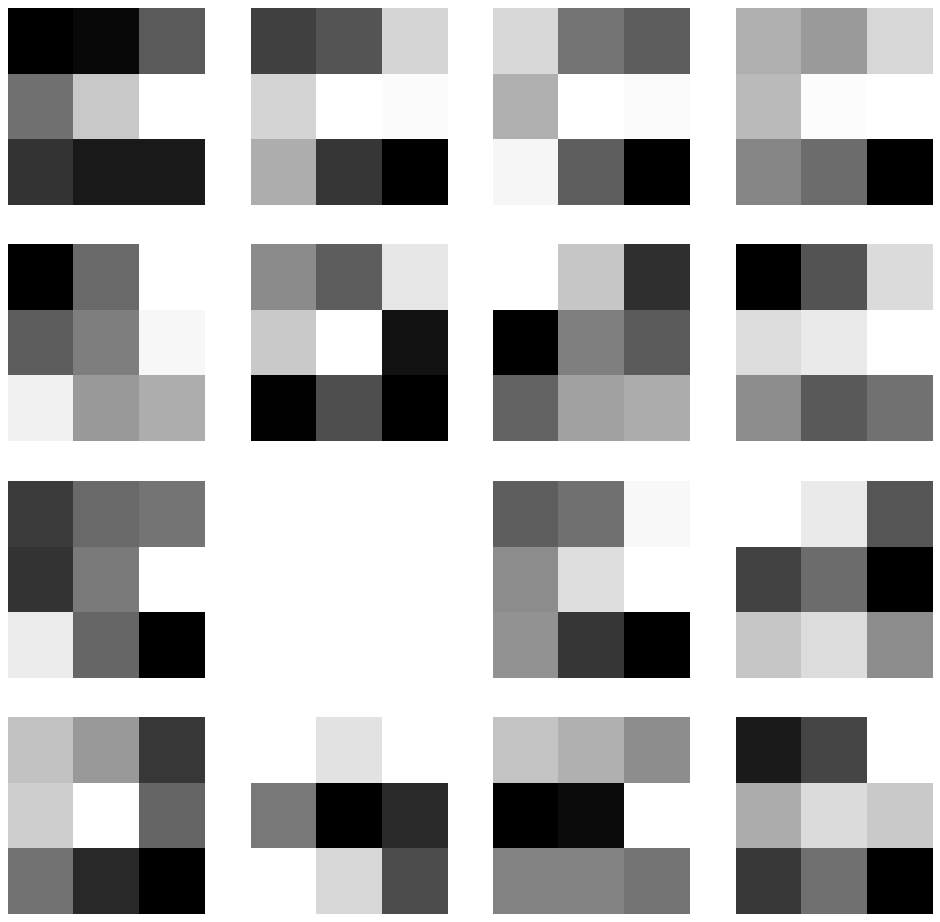

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?

In [0]:
'''
the filter has been fired for the white areas and has does been able to identify the edges of the thing in the picture.


'''

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [97]:
# 6.1.1
model_name = 'model_pooling_6.1.1'

input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',name='conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu',name='conv2d_2')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=2.45)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

hist_611 = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
703/703 [==============================] - 11s 15ms/step - loss: 14.4860 - acc: 0.1001 - val_loss: 14.1033 - val_acc: 0.1250

Epoch 00001: val_loss did not improve from 0.90353
Epoch 2/25
703/703 [==============================] - 10s 15ms/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.1033 - val_acc: 0.1250

Epoch 00002: val_loss did not improve from 0.90353
Epoch 3/25
703/703 [==============================] - 11s 16ms/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.1033 - val_acc: 0.1250

Epoch 00003: val_loss did not improve from 0.90353
Epoch 4/25
703/703 [==============================] - 12s 17ms/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.1033 - val_acc: 0.1250

Epoch 00004: val_loss did not improve from 0.90353
Epoch 5/25
703/703 [==============================] - 10s 15ms/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.1033 - val_acc: 0.1250

Epoch 00005: val_loss did not improve from 0.90353
Epoch 6/25
703/703 [==============================] - 10s 15

In [98]:
#6.1.2
model_name = 'model_pooling_6.1.2'

input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',name='conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu',name='conv2d_2')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.7)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

hist_612 = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
703/703 [==============================] - 11s 15ms/step - loss: 14.4935 - acc: 0.0997 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00001: val_loss did not improve from 0.90353
Epoch 2/25
703/703 [==============================] - 10s 14ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00002: val_loss did not improve from 0.90353
Epoch 3/25
703/703 [==============================] - 10s 15ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00003: val_loss did not improve from 0.90353
Epoch 4/25
703/703 [==============================] - 10s 14ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00004: val_loss did not improve from 0.90353
Epoch 5/25
703/703 [==============================] - 10s 14ms/step - loss: 14.5099 - acc: 0.0998 - val_loss: 14.6070 - val_acc: 0.0938

Epoch 00005: val_loss did not improve from 0.90353
Epoch 6/25
703/703 [==============================] - 10s 14

In [99]:
#6.1.3
model_name = 'model_pooling_6.1.3'

input_img = Input(shape=(input_shape_cifar), name='input_img')
#l = Conv2D(64, kernel_size=(3,3), activation='relu')(input_img)
l = Conv2D(64, kernel_size=(3,3),strides=(2,2),activation='relu',name='conv2d_1')(input_img)
#l = Conv2D(32, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(32, (3, 3),strides=(2,2),activation='relu',name='conv2d_2')(l)
l = Conv2D(16, (3, 3),strides=(2,2),activation='relu')(l)
l = Flatten()(l)
#l = Dense(128, activation='relu')(l)
l = Dense(32, activation='relu')(l)
output_class = Dense(num_classes, activation='softmax')(l)
model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

adam = Adam(lr=0.00001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

hist_613 = model_pooled.fit_generator(train_gen, epochs=epochs, steps_per_epoch=(len(train_files)//batch_size),
                           validation_data=(vald,valt),validation_steps=(len(val_files)//batch_size),
                           callbacks=callbacks, verbose=1)
all_histories.append(hist_pooled)

Epoch 1/25
703/703 [==============================] - 11s 15ms/step - loss: 2.2982 - acc: 0.1394 - val_loss: 2.2846 - val_acc: 0.1875

Epoch 00001: val_loss did not improve from 0.90353
Epoch 2/25
703/703 [==============================] - 10s 14ms/step - loss: 2.2808 - acc: 0.1785 - val_loss: 2.2546 - val_acc: 0.1719

Epoch 00002: val_loss did not improve from 0.90353
Epoch 3/25
703/703 [==============================] - 10s 14ms/step - loss: 2.2444 - acc: 0.1935 - val_loss: 2.1963 - val_acc: 0.2500

Epoch 00003: val_loss did not improve from 0.90353
Epoch 4/25
703/703 [==============================] - 10s 14ms/step - loss: 2.1909 - acc: 0.2006 - val_loss: 2.1318 - val_acc: 0.2344

Epoch 00004: val_loss did not improve from 0.90353
Epoch 5/25
703/703 [==============================] - 10s 14ms/step - loss: 2.1388 - acc: 0.2068 - val_loss: 2.0741 - val_acc: 0.2188

Epoch 00005: val_loss did not improve from 0.90353
Epoch 6/25
703/703 [==============================] - 10s 14ms/step - 

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

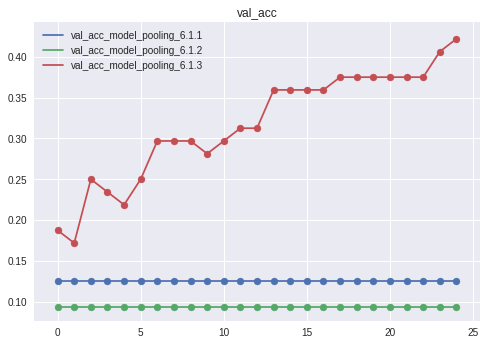

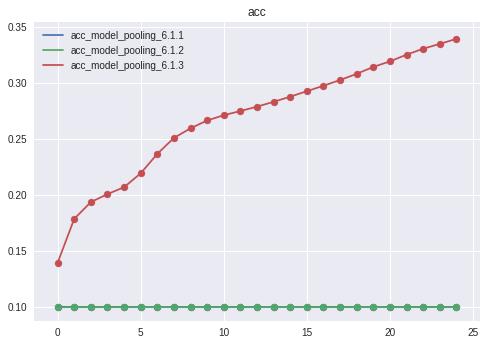

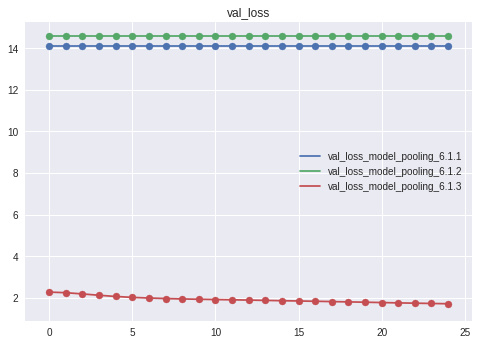

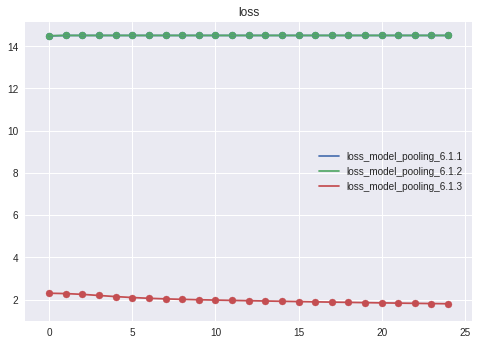

In [100]:
# Use plotHistory to make these plots
nam=['model_pooling_6.1.1','model_pooling_6.1.2','model_pooling_6.1.3']
all_histories1=[hist_611,hist_612,hist_613]
plotHistory(all_histories1,nam,'val_acc')
plotHistory(all_histories1,nam,'acc')
plotHistory(all_histories1,nam,'val_loss')
plotHistory(all_histories1,nam,'loss')

In [0]:
!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

zipname = 'base_model'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/base_model')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_batch_normalized'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_batch_normalized')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_dropout'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_dropout')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_pooling'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_pooling')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_preprocessed_input'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_preprocessed_input')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_pooling_611'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_pooling_6.1.1')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_pooling_612'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_pooling_6.1.2')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

In [0]:
zipname = 'model_pooling_613'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/model_pooling_6.1.3')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

Analysis:

6.1.1
Ans.When the learning rate is too high the val_loss,val_acc,acc and loss do not change very much. When the learning rate is set too high the model is unable to converge as in it is unable to find a minima in the gradient descent this is very apparent from the fact that the there is a constancy in the val_loss and other terms

6.1.2
again a similar thing happens as last part as we see that there is minimal change in val_loss and val_acc. the learning rate is too high and the model can't converge

6.1.3
we see that in this one the acc and val_acc improves but at a very slow rate. there is also a slow decreas in the loss too. we find that this learning rate is not optimal and while the model improves it takes too long.